Zakariyya Scavotto SSMIF Fall 2022 Coding Challenge: ML Problem

In [129]:
# Imports for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [130]:
# Read in the data the from csv file
# Don't need the date column, so will exclude it by selecting only Feature1-8 and Target column to work with when reading in the data from the csv file
df = pd.read_csv('ml_data.csv', usecols=['Feature1','Feature2','Feature3','Feature4','Feature5','Feature6','Feature7','Feature8','Target'])

# See what each column looks like by looking at the head of the DataFrame
df.head() # Columns: Feature1 Feature2 Feature3 Feature4 Feature5 Feature6 Feature7 Feature8 Target

# Looking at the head, feature 3 is strings, need to convert to float
df['Feature3'] = df['Feature3'].apply(lambda x: float(x.split()[0].replace('\'','')))

# Check data types now to make sure there are no miscellaneous strings or objects that will throw off computations later in the code
df.dtypes # float64, int64, float64, float64, float64, float64, float64, float64, float64

# Check for NaN values, since they require addressing in data preprocessing (or else they will throw off computations)
df.isna().sum() #  0, 0, 0, 837, 0, 0, 99, 0, 99

Feature1      0
Feature2      0
Feature3      0
Feature4    837
Feature5      0
Feature6      0
Feature7     99
Feature8      0
Target       99
dtype: int64

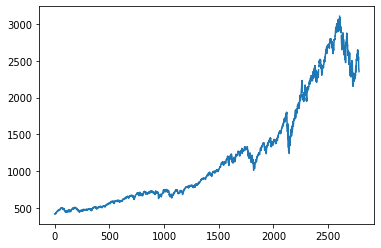

In [131]:
# Method to plot single features to get the general feel for the shape of the data in each column
def plotFeature(feature):
    df[feature].plot()
# plotFeature(Feature1) # Very sporadic looking with two main peaks, no real trend as far as I can tell visually
# plotFeature(Feature2) # Not a lot of unique data, everything in 90-100 range over time jumping up and down, overall seems very noisy
# plotFeature(Feature3) # Looks somewhat exponential-like, with a steep jump at around the 1700 mark
# plotFeature(Feature4) # Looks very linear, missing data at the start due to the NaN values
# plotFeature(Feature5) # Somewhat linear looking, and also like a bell curve in a way with the peak towards the end, but the tail down on the left
# plotFeature(Feature6) # Seems very exponential-like, aside from the weird spot at around 1700 could almost be perfectly modelled by an exponential function
# plotFeature(Feature7) # Very sporadic, similar trend by the looks of it to Feature6
# plotFeature(Feature8) # Very similar to Feature5 by the looks of it, but more volatile looking between days in comparison to Feature5's "straightness"
plotFeature('Target') # Has an exponential looking trend to it, very, very similar to Feature6 by the looks of it

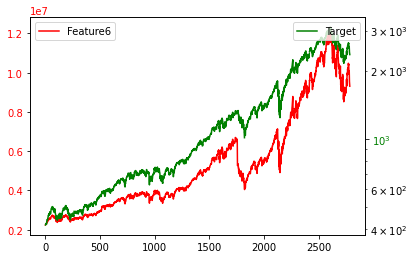

In [132]:
'''Method to plot two features on one graph to get an idea of how similar different features are to each other
or one feature to the target''';
def plotRelationships(feature1, feature2):
    # Create subplot structure, and plot the first feature on one axis
    fig, ax = plt.subplots()
    ax.plot(df[feature1], label = feature1, color='red')
    ax.tick_params(axis='y', labelcolor='red')

    # Creates a twin y-axis that shares the x axis, which will be used to plot the other feature, and plot the other feature
    ax2 = ax.twinx()
    ax2.plot(df[feature2],label=feature2, color='green')
    ax2.set_yscale('log')
    ax2.tick_params(axis='y', labelcolor='green')
    
    # Add legends to the plot, and put them in different spots to prevent overlap
    ax.legend()
    ax2.legend(loc = 'upper right')

'''There are many interesting relationships that can be graphed between Features and/or the Target, but I think the most interesting
    is the comparison between Feature6 and the Target since they share the same exact shape, but just shifted/scaled differently.''';
plotRelationships('Feature6','Target')

In [133]:
# This code cell handles the NaN values in the DataFrame
'''For feature 7 and target, since the data is moving forward in time, I decided to fill any missing gaps linearly,
since in those small windows of a few data points, the data follows an approximately linear relationship. 
Since the first row is NaN, and will not be changed with the interpolation since there is no past data, I decided to
put in the value for the row of the day after it, since the difference between the first and second day will be marginal.''';

df['Feature7']=df['Feature7'].interpolate(method='linear', limit_direction ='forward')
df['Target']=df['Target'].interpolate(method='linear', limit_direction ='forward')
df.at[0,'Feature7'] = df.at[1,'Feature7']
df.at[0,'Target'] = df.at[1,'Target']

'''Looking through the CSV file for Feature 4, there are only specific values on specific days to start,
which may indicate that feature is used for notifying if there was a major spike or dip in the market. 

Starting on 3/30/2015, that feature is full of 7s. So to compensate for the many days at the start where
there are no values, will fill these NaN values with a 0 to act as a dummy value so the rest of that feature
doesn't have to get thrown out over it. The 0s can be considered when the target is acting "normally" in a sense.

I have a hunch that Feature4 is used as a very specific marker for the target, so having the baseline 0s for the models to 
then compare with is a good idea.''';

df['Feature4']=df['Feature4'].replace(np.nan,0)

# Now, there are no missing values in the DataFrame
df.isna().sum() 

Feature1    0
Feature2    0
Feature3    0
Feature4    0
Feature5    0
Feature6    0
Feature7    0
Feature8    0
Target      0
dtype: int64

In [134]:
# Make correlation matrix to see which features are most correlated with the target
corr = df.corr()
print(corr)

'''From the correlation matrix, we can see that 3 of the features (Feature3, Feature6, and Feature7) have a correlation of over 0.9 with the target.
Speaking of Feature6, it features a 0.99 correlation with the Target. So as I predicted with the graphs, they are very similar.

We can also see that some features have strong correlations with each other, indicating multicolinearity between the varibles. 
For example, Feature3 and Feature6 have a correlation of 0.93, and Feature5 and Feature8 have a correlation of 0.92.''';

          Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  \
Feature1  1.000000 -0.015493  0.102707 -0.190018 -0.182934  0.091822   
Feature2 -0.015493  1.000000 -0.033049 -0.034542 -0.026728 -0.027703   
Feature3  0.102707 -0.033049  1.000000  0.443319  0.771473  0.932508   
Feature4 -0.190018 -0.034542  0.443319  1.000000  0.648200  0.454351   
Feature5 -0.182934 -0.026728  0.771473  0.648200  1.000000  0.737058   
Feature6  0.091822 -0.027703  0.932508  0.454351  0.737058  1.000000   
Feature7 -0.004347 -0.026400  0.818815  0.483751  0.786673  0.937102   
Feature8 -0.115118 -0.015712  0.814450  0.617536  0.928318  0.785695   
Target    0.111473 -0.030980  0.960788  0.439322  0.747800  0.991483   

          Feature7  Feature8    Target  
Feature1 -0.004347 -0.115118  0.111473  
Feature2 -0.026400 -0.015712 -0.030980  
Feature3  0.818815  0.814450  0.960788  
Feature4  0.483751  0.617536  0.439322  
Feature5  0.786673  0.928318  0.747800  
Feature6  0.937102  0.785695  0.9

Part 1: Linear Regression Model

Because we are unsure about which features should have the strongest weighting and are the most significant to the regression, the regression should be made as a form of a stepwise regression so that the computer will check every possible combination of the features, and determine what combination will yield the best results.

References for understanding the concepts with the regression:
https://www.investopedia.com/terms/s/stepwise-regression.asp
https://machinelearningcompass.com/machine_learning_models/ridge_regression/
https://machinelearningcompass.com/machine_learning_models/lasso_regression/

Because I do not know how to program a linear regression only using numpy from scratch (I can do regressions using packages like scikit-learn and I can understand how the code works looking at it, I have a hard time understanding the programming behind the regression to make it myself from scratch), here is the reference for the code I used for doing the linear regression. I added onto this code to turn the regression into more of a stepwise regression where the computer determiens what features yield the best results:
https://euanrussano.github.io/20190810linearRegressionNumpy/

In [135]:
# Method to calculate the gradient of the theta parameters, to be used in the gradient descent
def grad(theta, xTrainNormalized, yTrainNormalized):
    dJ = 1/len(xTrainNormalized)*np.sum((xTrainNormalized.dot(theta)-yTrainNormalized)*xTrainNormalized,axis=0).reshape(-1,1)
    return dJ

# Method to calculate the cost function to see the sum of the squared errors using the current theta parameters
def cost(theta, xTrainNormalized, yTrainNormalized):
    J = np.sum((xTrainNormalized.dot(theta)-yTrainNormalized)**2,axis=0)[0]
    return J

In [136]:
'''Method for doing the gradient descent on the model (training the model by iteratively changing the parameters theta 
to reduce the error in the regression, until the difference between the previous set of parameters and the current ones
is below the tolerance level, meaning that the model has converged and finished training.''';
def GD(theta0, xTrainNormalized, yTrainNormalized,learning_rate = 0.5,epochs=100000,TOL=1e-7):
    '''History tracking for print logging to keep track of the training progress, commented out since I'm not printing
    the history of the training (explained below withe the print statement comment)''';
    # theta_history = [theta0]
    # J_history = [cost(theta0, xTrainNormalized,yTrainNormalized)]
    
    thetanew = theta0*10000
    # print(f'epoch \t Cost(J) \t') 
    '''This line ^ can be uncommented if you want to see the training steps, but because of my code's long output for the stepwise
    regression, the extra print statements would be overkill due to the number of combinations of features the code goes through
    in the stepwise regression''';

    # For as many epochs as is specified
    for epoch in range(epochs):
        # if epoch%100 == 0:
        #     print(f'{epoch:5d}\t{J_history[-1]:7.4f}\t')

        # Calculate the gradient as well as the error
        dJ = grad(theta0,xTrainNormalized, yTrainNormalized,)
        J = cost(theta0,xTrainNormalized, yTrainNormalized,)

        # Update theta parameters based on the gradient and the learning rate, doing the gradient descent
        thetanew = theta0 - learning_rate*dJ
        # theta_history.append(thetanew) Cncomment this line and the below line if using the prints
        # J_history.append(J)
        # If the change in theta parameters is less than the tolerance, the model has converged
        if np.sum((thetanew - theta0)**2) < TOL:
            # print('Convergence achieved.') commented out due to excess prints
            break
        theta0 = thetanew

    return thetanew #,theta_history,J_history # Uncomment if using the prints

In [137]:
# This code cell handles the stepwise regression feature selection. Warning: it does take some time to run (usually around 5 minutes) since it tries all of the possible combinations of features
from itertools import combinations # Used ONLY to get every combination of the features for the stepwise regression

bestFeatures, bestSSE, bestTheta, bestPredictions = [], 99999999999999999, [], []

featureList = ['Feature1','Feature2','Feature3','Feature4','Feature5','Feature6','Feature7','Feature8']

for n in range(1,9):
    print('Current number of Features in a Combination: ',n)
    featureCombinationsOfLengthN = list(combinations(featureList,n)) # Gets the list of all feature combinations to try

    for combination in featureCombinationsOfLengthN:
        # Create a copy of the DataFrame to manipulate with column removals
        tempDF = df.copy(deep=True)
        # Need to keep target in the columns for the combination, so adding it onto the combination
        combination += ('Target',) 
        
        # Split data between training and testing (75/25 train/test split)
        tempDF = tempDF[tempDF.columns.intersection(combination)] #drop features that aren't needed
        train=tempDF.sample(frac=0.75,random_state=42) # picked a random state to have more consistent results when working on my code
        test=tempDF.drop(train.index)

        # Split the training and testing sets between X (the features) and Y (the target) 
        xTrain = train.loc[:,train.columns != 'Target'].values  
        yTrain = train.loc[:,train.columns == 'Target'].values
        xTest  = test.loc[:,test.columns != 'Target'].values 
        yTest = test.loc[:,test.columns == 'Target'].values

        # Normalize the data to prevent large values from having too large of an influence
        xTrainNormalized = xTrain/ np.linalg.norm(xTrain)
        yTrainNormalized = yTrain / np.linalg.norm(yTrain)
        xTestNormalized = xTest / np.linalg.norm(xTest)
        yTestNormalized = yTest / np.linalg.norm(yTest)

        # Initialize starting set of theta parameters, one weight for each feature
        theta0 = np.zeros((xTrainNormalized.shape[1],1))+5
        # Do the gradient descent to find the final theta parameters using the training data
        theta = GD(theta0, xTrainNormalized, yTrainNormalized)

        # Utilize the testing data to evaluate the model's accuracy by having the model predict what the y values should be
        yprednorm = xTestNormalized.dot(theta)
        
        # Evaluate the model accuracy by finding the Sum of Squares Error (SSE), 
        sumSquaredError = np.sum((yprednorm-yTestNormalized)**2,axis=0)[0]
        # If the current model has the lowest SSE, save that SSE, the features that got that result, as well as the parameters theta (to avoid having to retrain)
        if sumSquaredError < bestSSE:
            bestSSE = sumSquaredError
            print('New bestSSE: ',bestSSE)
            bestFeatures = combination
            bestTheta = theta
            bestPredictions = yprednorm

Current number of Features in a Combination:  1
New bestSSE:  2.00079191396082
New bestSSE:  1.829119909951265
New bestSSE:  1.7562819071732942
Current number of Features in a Combination:  2
New bestSSE:  1.7560521318748106
Current number of Features in a Combination:  3
Current number of Features in a Combination:  4
Current number of Features in a Combination:  5
Current number of Features in a Combination:  6
Current number of Features in a Combination:  7
Current number of Features in a Combination:  8


In [138]:
# Get the R^2 of the best result
meanActual = np.mean(yTestNormalized)
SSR = np.sum((bestPredictions-yTestNormalized)**2,axis=0)[0]
SST = np.sum((bestPredictions-meanActual)**2, axis=0)[0]
r2 = 1 - SSR/SST

# Output the best results
print('Best Features: ',bestFeatures[:-1]) # Go up to -1 to not include the Target in the output
print('Best Theta: ',bestTheta)
print('Best r^2: ',r2)

Best Features:  ('Feature6', 'Feature8')
Best Theta:  [[2.3124847 ]
 [4.99962243]]
Best r^2:  0.3021846281959222


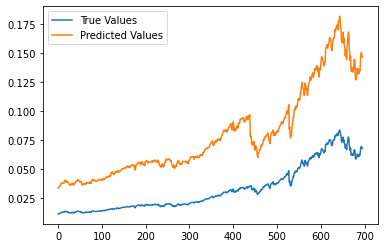

In [139]:
sortidx = np.argsort(yTestNormalized[:,0])
plt.plot(yTestNormalized, label = 'True Values')
plt.plot(bestPredictions, label = 'Predicted Values')
plt.legend()

'''In the end, the stepwise linear regression model that I created is able to somewhat successfully predict the data.
It is able to follow the general shape of the actual data values, as shown in the below graph.
However, it is off when it comes to the numerical scale and values, which is exemplified by its r^2 score of 0.302.

Something that I had tried to improve the accuracy of my model is taking the log of the Target values, the log of the features, and the log of both.
I had decided to do this because I saw in the graphs that the data followed a somewhat exponential trend, so I thought that doing a log transform would
make the data appear more linear, in turn not only making it easier for the linear regression to be created, but also make it more accurate.
Upon testing the log transforms, I found that it did not improve the accuracy of the regression in any way, so I decided to leave the data untransformed.

I have removed the code and graphs associated with the log transforms from my submission, but I can send that version of the code and/or some of the graphs 
if whoever is reviewing my code would like to see it.''';

In [140]:
# For fun, I decided to compare the stepwise linear regression I did to sklearn's pre-trained LinearRegression model

# First, I need to recreate the original training/testing datasets but with all the features included
train=df.sample(frac=0.75,random_state=42) # picked a random state to have more consistent results when working on my code
test=df.drop(train.index)

# Split the training and testing sets between X (the features) and Y (the target) 
xTrain = train.loc[:,train.columns != 'Target'].values  
yTrain = train.loc[:,train.columns == 'Target'].values
xTest  = test.loc[:,test.columns != 'Target'].values 
yTest = test.loc[:,test.columns == 'Target'].values

# Normalize the data to prevent large values from having too large of an influence
xTrainNormalized = xTrain/ np.linalg.norm(xTrain)
yTrainNormalized = yTrain / np.linalg.norm(yTrain)
xTestNormalized = xTest / np.linalg.norm(xTest)
yTestNormalized = yTest / np.linalg.norm(yTest)

MSE:  0.00017496846134617059
R^2:  0.5492477757150758


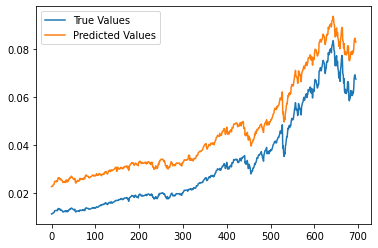

In [141]:
# Now, make the linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Create the model and fit it on the data
testModel = LinearRegression()
testModel.fit(xTrainNormalized, yTrainNormalized)

# Predict values based on the testing set
yPred = testModel.predict(xTestNormalized)

# Plot for comparison
plt.plot(yTestNormalized, label='True Values')
plt.plot(yPred, label = 'Predicted Values')
plt.legend()

# Get MSE for quantifiable comparison
print('MSE: ',mean_squared_error(yTestNormalized, yPred))
print('R^2: ',r2_score(yTestNormalized, yPred))

'''Looking at the graph, it is evident that sklearn's model is not only more accurate at following the shape of the data,
but also with being closer numerically to the true values. 
This is quantifiably shown by the sklearn linear regression having a better r^2 than my linear regression by approximately 0.2.''';

Part 2: Training any ML model on the data

For this part of the problem, I opted to using a polynomial regression on the data (using the same data that was preprocessed and split for the first part for making the sklearn linear regression). I decided to utilize a polynomial regression since when I looked at the graph of the target column (in the code cell towards the start of my code where the different feature or target columns can be plotted), it reminded me of a very wide looking parabola. For this reason, I decided to utilize sklearn's PolynomialFeatures class to generate a "polynomial" version of the features that would then be passed into a BayesianRidge regression (a regression that uses probability distributions rather than point estimates) model to do the polynomial regression. In the end, this worked very well, achieving a MSE of around 2.16*10^-5 and a R^2 of 0.944, indicating a model that can successfully predict on the given data. However, if the model needs to generalize outside of the 2012-2022 time range, the model is likely overfit and would not be able to predict well outside of that 10 year time range.

Best degree for polynomial regression:  2
Best MSE:  2.1641156266397183e-05
Best R^2:  0.9442482419510078


c:\Users\Owner\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


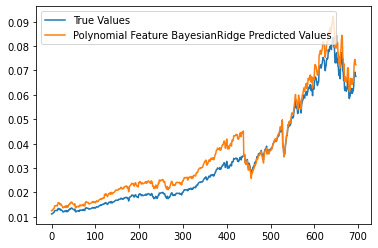

In [142]:
# Import PolynomialFeatures for the polynomial transformation, the BayesianRidge regression model, and pipeline to make the two into a single pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline

# Initialize "best" variables, and the degrees of the polynomial transformation to be tested
bestDegree, bestMSE, degrees = 0, 9999999999, [2,3,4,5]

'''To determine what degree of the polynomial transformation works best, I decided to iterate over different possible values for the degree of the polynomial,
and the polynomial degree that achieved the lowest MSE is the one that was saved to be re-trained as the final model.''';

for degreeVal in degrees:
    # Create the model as a pipeline that first transforms the data to the polynomial shape, then does the linear regression on the transformed data
    model = Pipeline([('poly', PolynomialFeatures(degree=degreeVal)),('linear', LinearRegression(fit_intercept=False))])

    # Fit the model on the training data, and predict with the testing data
    model = model.fit(xTrainNormalized, yTrainNormalized)
    preds = model.predict(xTestNormalized)

    # Get the MSE of the model
    currentMSE = mean_squared_error(yTestNormalized, preds)
    
    # If this model has the lowest MSE seen, save the value of the degree of the polynomial
    if  currentMSE < bestMSE:
        bestMSE = currentMSE
        bestDegree = degreeVal

# Recreate the model, but using the best degree found for the degree of the PolynomialFeatures
model = Pipeline([('poly', PolynomialFeatures(degree=bestDegree)),('linear', BayesianRidge(fit_intercept=False))])

# Retrain the model on the training data and predict on the testing data
model = model.fit(xTrainNormalized, yTrainNormalized)
preds = model.predict(xTestNormalized)

# Output the results, the best degree as well as the MSE of the model with the best degree
print('Best degree for polynomial regression: ',bestDegree)
print('Best MSE: ',mean_squared_error(yTestNormalized, preds))
print('Best R^2: ',r2_score(yTestNormalized, preds))

# Plot the testing data and predictions for a visual comparison
plt.plot(yTestNormalized, label='True Values')
plt.plot(preds, label='Polynomial Feature BayesianRidge Predicted Values')
plt.legend()

'''The BayesianRidge regression with a polynomial transformation of degree 2 on the features does a very good job predicting the data, 
as shown by the R^2 value of 0.994 and the MSE of 2.16*10^-5.

However, if this model needs to be utilized outside of the 2012-22 timeframe given in the data, the model is very overfit since it does 
a very good job predicting on the training/testing data it was given, but would likely not perform too well predicting outside of this range. 

To fix this, the model would need to be retrained with some solutions to make it more generalized. Some solutions I can think of include:
1) Using fewer features to be able to generalize better outside of the training data. 
2) Utilizing less data in training and saving more of the data for testing.
3) Using a different type of regression model that may be better at generalizing outside of the data it is given in training/testing.''';